전체적인 과정
============
**1.데이터 변환**  
 1-1)NaN 데이터 처리하기  
 1-2)Store별 batch 학습을 위한 가게 고유값 도출하기 및 함수화  
 1-3)train 데이터 형식이 분활해서 가진 date, time을 합친 후 index로 변환해서 시계열로 데이터로 완성하기  
 **1-4)결제시각에 대한 데이터를 일단위 데이터로 변환 -->(모델 개선방법: holyday 값도 train 및 test 데이터에 포함시키도로 하여 모델 값 개선!)**  
  ```pyhton  
  from pandas.tseries.holiday import USFederalHolidayCalendar  
  Calendar = USFederalHolidayCalendar()  
  holidays = calender.holidays('2016','2017','2018')
  ....  
  train_batch = train_batch.join(pd.Series(1, index= holidays, name='holyday')  
  ....  
  test_batch = test.batch.join(pd.Series(1, index=holidays, name='holyday')  
  ```
 1-5) amount만 존재하는 시계열 데이터프레임에 날짜 데이터 추가 **각 요일별 one-hot 레이블 입력**
 1-6) 1-2에서 1-5R까지의 과정을 처리하는 transform 함수 완성하기.
**2.데이터 시각화**  
 2-1)각 날짜별 매출 (각 store_id에 따라 시각화 결과가 다른 것을 알 수 있음.)  
 2-2)요일별 매출량  
 2-3)평일, 주말 각각의 매출량 시각별 시각화

**3.모델 학습 (LinearRegression model 사용) ->batch 학습 구조**  
**4.test 데이터 입력 후 결과 값 리턴(100일 이후의 데이터값 획득 후 누계 매출 값)

In [1]:
#importing libraries that needed.
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn; seaborn.set()
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
#import files data
Raw = pd.read_csv("train.csv") #data shape 3362796 x 8
test_raw = pd.read_csv("test.csv")
submit=pd.read_csv("submission.csv")

In [3]:
#data cleaning 
#1.NaN data finding
Raw.isnull()  #Installments have lots of NaN

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,False,False,False,False,False,True,False,False
1,False,False,False,False,False,True,False,False
2,False,False,False,False,False,True,False,False
3,False,False,False,False,False,True,False,False
4,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...
3362791,False,False,False,False,False,True,False,False
3362792,False,False,False,False,False,True,False,False
3362793,False,False,False,False,False,True,False,False
3362794,False,False,False,False,False,True,False,False


In [4]:
#2.Fill NaN data with 0
Raw = Raw.fillna(0)
print(Raw)

         store_id        date      time     card_id  amount  installments  \
0               0  2016-12-14  18:05:31  d297bba73f       5           0.0   
1               0  2016-12-14  18:05:54  d297bba73f      -5           0.0   
2               0  2016-12-19  12:42:31  0880849c05     144           0.0   
3               0  2016-12-19  12:48:08  8b4f9e0e95      66           0.0   
4               0  2016-12-19  13:31:08  7ad237eed0      24           0.0   
...           ...         ...       ...         ...     ...           ...   
3362791      1799  2018-07-19  17:58:31  e254bf70d9     600           0.0   
3362792      1799  2018-07-19  18:54:34  8f41c89891     275           0.0   
3362793      1799  2018-07-22  14:46:57  aeb64fe1fb     350           0.0   
3362794      1799  2018-07-25  18:09:13  57932602d6     300           0.0   
3362795      1799  2018-07-30  10:58:53  42d354807a     325           0.0   

         days_of_week  holyday  
0                   2        0  
1        

In [5]:
#3.Store store_id data for slicing data for each cases
id = Raw['store_id'].unique()
print(id)

[   0    1    2 ... 1797 1798 1799]


In [6]:
#store_id별로 데이터 나누는 함수
def sortid(id):
    case = Raw.store_id ==id #bool 형식으로 데이터 나누기
    store_sales = Raw[case]
    return store_sales
sales = sortid(0)
print(sales)

       store_id        date      time     card_id  amount  installments  \
0             0  2016-12-14  18:05:31  d297bba73f       5           0.0   
1             0  2016-12-14  18:05:54  d297bba73f      -5           0.0   
2             0  2016-12-19  12:42:31  0880849c05     144           0.0   
3             0  2016-12-19  12:48:08  8b4f9e0e95      66           0.0   
4             0  2016-12-19  13:31:08  7ad237eed0      24           0.0   
...         ...         ...       ...         ...     ...           ...   
68768         0  2018-07-31  23:12:44  b07b89c873      74           0.0   
68769         0  2018-07-31  23:16:50  8d4822aa74      97           0.0   
68770         0  2018-07-31  23:40:24  f985e806d7      49           0.0   
68771         0  2018-07-31  23:55:10  2748138407      29           0.0   
68772         0  2018-07-31  23:56:14  de21ab0098      13           0.0   

       days_of_week  holyday  
0                 2        0  
1                 2        0  
2     

In [7]:
#4.Transforming Dataframe sturcture
print(sales.dtypes)#checking the data types
sales['payment_time']=sales.loc[:,'date']+ ' ' +sales.loc[:,'time'] 
period = sales['date'].unique()
sales['payment_time']=pd.to_datetime(sales['payment_time'])
print(sales.dtypes)#checking the data types to check 
train_batch= sales.set_index('payment_time') #changing index
train_batch = train_batch.loc[:,('amount')]
print(train_batch)

store_id          int64
date             object
time             object
card_id          object
amount            int64
installments    float64
days_of_week      int64
holyday           int64
dtype: object
store_id                 int64
date                    object
time                    object
card_id                 object
amount                   int64
installments           float64
days_of_week             int64
holyday                  int64
payment_time    datetime64[ns]
dtype: object
payment_time
2016-12-14 18:05:31      5
2016-12-14 18:05:54     -5
2016-12-19 12:42:31    144
2016-12-19 12:48:08     66
2016-12-19 13:31:08     24
                      ... 
2018-07-31 23:12:44     74
2018-07-31 23:16:50     97
2018-07-31 23:40:24     49
2018-07-31 23:55:10     29
2018-07-31 23:56:14     13
Name: amount, Length: 68773, dtype: int64


Text(0, 0.5, 'Amount of Sales')

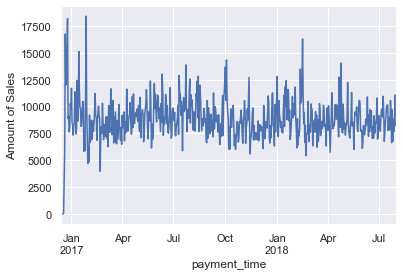

In [8]:
#Seeing the data for some standards
daily = train_batch.resample('D').sum()
daily.plot()
plt.ylabel("Amount of Sales") #See example of data plot of daily sales.

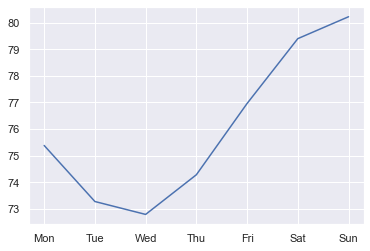

In [9]:
#See example of mean of sales for each day of the week.
weekday=train_batch.groupby(train_batch.index.dayofweek).mean()
weekday.index= ['Mon', 'Tue','Wed','Thu', 'Fri', 'Sat', 'Sun']
weekday.plot()

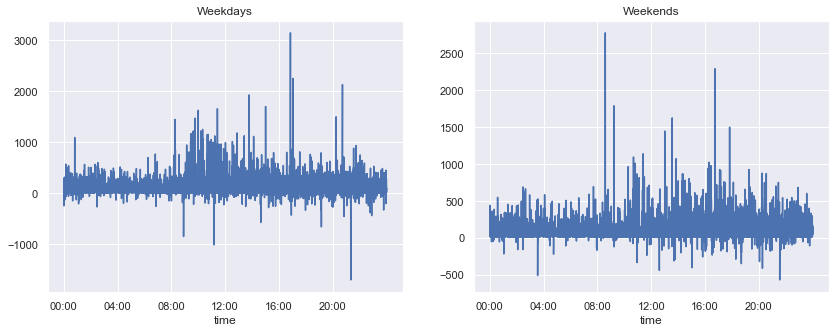

In [10]:
#See each times sales of weeekdays and weekends
happy_day= np.where(train_batch.index.weekday < 5, 'Weekday', 'Weekend')
by_time = train_batch.groupby([happy_day, train_batch.index.time]).mean()
fig, ax = plt.subplots(1,2, figsize=(14,5))
hourly_ticks= 4*60*60*np.arange(6)
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',xticks=hourly_ticks)
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',xticks=hourly_ticks)

In [11]:
#train_batch_tf=pd.DataFrame()
train_batch = train_batch.resample('d').sum()
#train_batch_tf['holyday'] = train_batch['holyday'].resample('d').max()
#train_batch_tf=train_batch_tf.fillna(0)
print(train_batch)

payment_time
2016-12-14        0
2016-12-15        0
2016-12-16        0
2016-12-17        0
2016-12-18        0
              ...  
2018-07-27     7668
2018-07-28     8404
2018-07-29    11067
2018-07-30     8210
2018-07-31     9116
Freq: D, Name: amount, Length: 595, dtype: int64


In [12]:
days = ['Mon', 'Tue','Wed','Thu', 'Fri', 'Sat', 'Sun']
train_batch = train_batch.to_frame()
total_period=pd.date_range(period[0], period[-1])
weekday_produce =pd.DataFrame({'date': total_period})
for i in range(7):
    train_batch[days[i]]= (weekday_produce['date'].dt.dayofweek ==i).astype(int).values
print(train_batch)


              amount  Mon  Tue  Wed  Thu  Fri  Sat  Sun
payment_time                                           
2016-12-14         0    0    0    1    0    0    0    0
2016-12-15         0    0    0    0    1    0    0    0
2016-12-16         0    0    0    0    0    1    0    0
2016-12-17         0    0    0    0    0    0    1    0
2016-12-18         0    0    0    0    0    0    0    1
...              ...  ...  ...  ...  ...  ...  ...  ...
2018-07-27      7668    0    0    0    0    1    0    0
2018-07-28      8404    0    0    0    0    0    1    0
2018-07-29     11067    0    0    0    0    0    0    1
2018-07-30      8210    1    0    0    0    0    0    0
2018-07-31      9116    0    1    0    0    0    0    0

[595 rows x 8 columns]


In [13]:
x_train = train_batch[days]
y_train = train_batch['amount']
model = LinearRegression(fit_intercept = False)
model.fit(x_train, y_train)

LinearRegression(fit_intercept=False)

In [14]:
def transform(sales):
    sales['payment_time']=sales.loc[:,'date']+ ' ' +sales.loc[:,'time'] 
    period = sales['date'].unique()
    sales['payment_time']=pd.to_datetime(sales['payment_time'])
    train_batch= sales.set_index('payment_time') #changing index
    train_batch = train_batch.loc[:,('amount')]
    train_batch = train_batch.resample('d').sum()
    days = ['Mon', 'Tue','Wed','Thu', 'Fri', 'Sat', 'Sun']
    train_batch = train_batch.to_frame()
    total_period=pd.date_range(period[0], period[-1])
    weekday_produce =pd.DataFrame({'date': total_period})
    for i in range(7):
        train_batch[days[i]]= (weekday_produce['date'].dt.dayofweek ==i).astype(int).values
    return train_batch

In [15]:
for i in id:
    sales= sortid(i)
    train_batch = transform(sales)
    x_train = train_batch[days]
    y_train = train_batch['amount']
    model = LinearRegression(fit_intercept = False)
    model.fit(x_train, y_train)

In [16]:
test_raw = test_raw.fillna(0)
test_id = test_raw['store_id'].unique()
result= []
for i in test_id:
    case = test_raw.store_id == i #bool 형식으로 데이터 나누기
    store_sales = test_raw[case]
    period = store_sales['date'].unique()
    total_period=pd.date_range(pd.to_datetime(period[-1])+ timedelta(days = 1),periods= 100)
    test_batch =pd.DataFrame({'date': total_period, 'amount' : 0})
    for i in range(7):
        test_batch[days[i]]= (test_batch['date'].dt.dayofweek ==i).astype(int).values
    test_batch= test_batch.set_index('date') #changing index
    test_batch = test_batch[days]
   
    result.append(model.predict(test_batch).sum())
submit['total_sales']= result
print(submit)
print(submit.dtypes)

     store_id   total_sales
0           0  38039.932268
1           1  38369.480213
2           2  38369.480213
3           3  38039.932268
4           4  38039.932268
..        ...           ...
195       195  38039.932268
196       196  38369.480213
197       197  37771.252664
198       198  38369.480213
199       199  38039.932268

[200 rows x 2 columns]
store_id         int64
total_sales    float64
dtype: object


In [17]:
submit.to_csv('submission.csv', index = False)